# Домашнее задание 3. Алгоритмы кластеризации

Основная задача этого задания -- реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [1]:
import pandas as pd
import matplotlib.pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [2]:
data_df = pd.read_csv("hw2_out.csv", sep="\t", header=0, index_col="twitter_id")
x = data_df.values

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы.

In [3]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("a.ospanov") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [4]:
class Clustering:
    """
    Implement clustering algorithm according 
    """

    def __init__(self, k, linkage, **kwargs):
        self.k = k
        self.linkage = linkage

    
    def fit(self, X, y=None):
        """
        X - numpy.ndarray
        """
        self.y = y

        return self

    
    def predict(self, X):
        """
        X - numpy.ndarray
        """
        self.elemsNum = X.shape[0]

        if (self.y is None):
            self.clustNum = X.shape[0]
            self.clusters = {i : [i] for i in xrange(self.elemsNum)}

        self.distMatrix = ss.distance.cdist(X, X)
        
        dM = np.copy(self.distMatrix)
        
        self.distMatrix -= 0.000001
        self.distMatrix[self.distMatrix < 0] = np.inf

        rows, cols = self.distMatrix.shape

        while (self.clustNum > self.k):
            
            amin = np.argmin(self.distMatrix)
            i, j = amin / cols, amin % cols
            
            if (self.linkage == 'single-linkage'):
                self.distMatrix[i] = np.minimum(self.distMatrix[i], self.distMatrix[j])
            
            elif (self.linkage == 'complete-linkage'):
#                 self.distMatrix[i] = np.maximum(self.distMatrix[i], self.distMatrix[j])
                for k in np.sort(self.clusters.keys()):
                    self.distMatrix[i][k] = np.max(dM[self.clusters[i]][:, self.clusters[k]])
                
            elif (self.linkage == 'average-linkage'):
#                 self.distMatrix[i] = (self.distMatrix[i] + self.distMatrix[j]) / 2
                for k in np.sort(self.clusters.keys()):
                    self.distMatrix[i][k] = np.mean(dM[self.clusters[i]][:, self.clusters[k]])
                
            else:
                raise ValueError("unknown linkage type")

            self.distMatrix[:, i] = self.distMatrix[i]
            self.distMatrix[:, j] = np.inf
            self.distMatrix[j] = np.inf
            self.distMatrix[i, i] = np.inf
            
            self.clusters[i] += self.clusters[j]
            self.clusters.pop(j)
            
            self.clustNum -= 1

        y = np.zeros(self.elemsNum, dtype=np.int)
        i = 0
        for key in self.clusters:
            y[self.clusters[key]] = i
            i += 1

        return y
    
    def fit_predict(self, X, y=None):
        self.fit(X, y)
        return self.predict(X)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

/home/ospanoff/.pyenv/versions/python2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


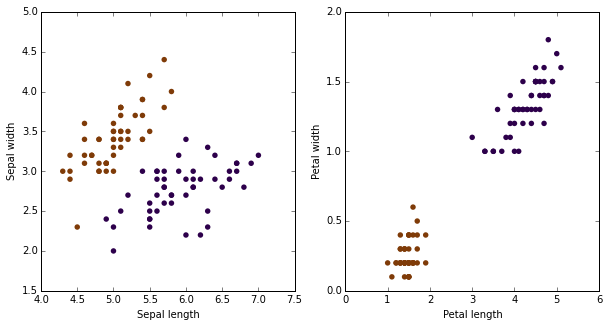

In [5]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [6]:
for lkg in ['single-linkage', 'complete-linkage', 'average-linkage']:
    pred_iris = Clustering(2, lkg).fit_predict(x_iris)
    print "Adjusted Rand index for iris with %s param is: %.2f" % (lkg, smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris with single-linkage param is: 1.00
Adjusted Rand index for iris with complete-linkage param is: 1.00
Adjusted Rand index for iris with average-linkage param is: 1.00


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [7]:
def quality(X, y):
    """
    Average diameter
    X - np.ndarray
    y - np.ndarray
    """
    q = 0
    for c in set(y):
        M = X[np.where(y == c)[0]]
        q += np.max(ss.distance.pdist(M) if len(M) > 1 else [0])
        
    return q / len(set(y))

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

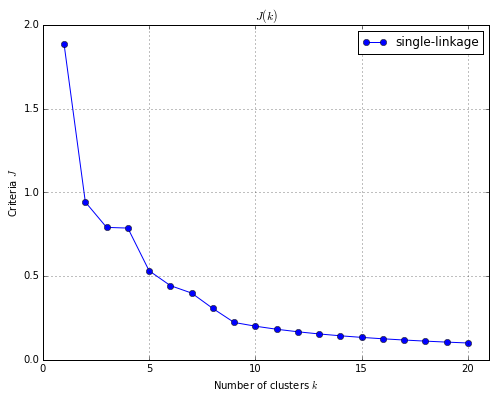

In [8]:
ks = range(1, 21)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Clustering(k, 'single-linkage') # the fastest was chosen
    y = cls.fit_predict(x)
    criteria[i] = quality(x, y)
    
pl.figure(figsize=(8, 6))
pl.ylim((0, 2))
pl.xlim((0, 21))
pl.plot(ks, criteria, marker='o', label='single-linkage')
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.legend(loc='best')
pl.grid()
pl.show()

In [9]:
criteria

array([ 1.88482925,  0.94241462,  0.79102326,  0.78690548,  0.53187628,
        0.44323023,  0.39863887,  0.30651327,  0.22308918,  0.20078026,
        0.18252751,  0.16731688,  0.15444635,  0.14341447,  0.13385351,
        0.12548766,  0.11810604,  0.11154459,  0.10567382,  0.10039013])

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

In [10]:
k = 6
cls = Clustering(k, 'complete-linkage')
%time y = cls.fit_predict(x)

CPU times: user 1min 43s, sys: 24 ms, total: 1min 43s
Wall time: 1min 43s


Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png)). Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко? Какой вывод можно сделать о качестве кластеризации?

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 2999
[t-SNE] Computed conditional probabilities for sample 2000 / 2999
[t-SNE] Computed conditional probabilities for sample 2999 / 2999
[t-SNE] Mean sigma: 0.120491
[t-SNE] Error after 83 iterations with early exaggeration: 20.277555
[t-SNE] Error after 322 iterations: 2.170322


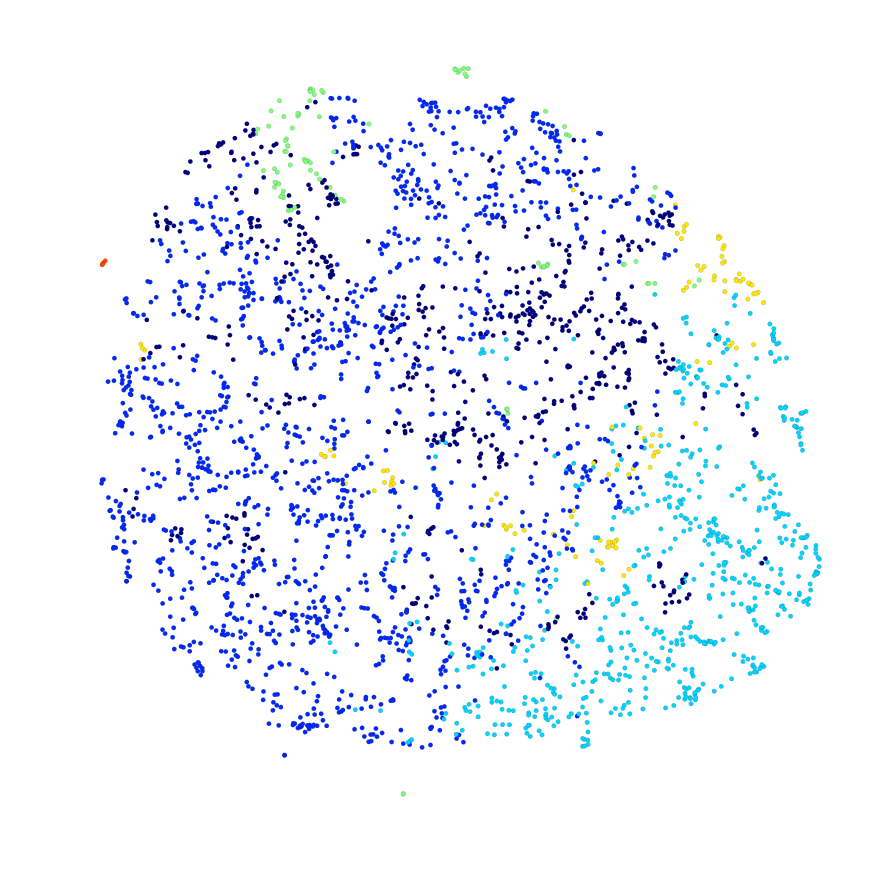

In [12]:
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(x)

# Color map
cm = pl.get_cmap('jet')
pl.figure(figsize=(15, 15))
pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / k), y), linewidths=0.1)
pl.axis('off')
pl.show()

- <b>Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко?</b> <br>
В общем случае - нет! Но t-SNE сделан так, чтобы близость в новом пространстве сохранялась. Поэтому в нашей картинке объекты с одного кластера находятся относительно недалеко.

- <b>Какой вывод можно сделать о качестве кластеризации?</b> <br>
Для данной задачи с иерархической кластеризацией лучше всего подошел параметр complete-linkage. В этом случае в каждом кластере существенное количество объектов. Если выбрать параметры single-linkage или average-linkage, то выделится один кластер с большинством элементов, а остальные кластеры будут иметь по два-три элемента.

Попробуем проанализировать полученные кластеры. Для того, чтобы интерпретировать "суть" каждого из кластеров, построим [radar plot](http://www.wikiwand.com/en/Radar_chart), отображающий их центроиды. Посмотрите на графики и попробуйте объяснить, каким поведением можно охарактеризовать каждый из полученных кластеров? Есть ли среди кластеров похожие?

Реализация радара позаимствована отсюда: 
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

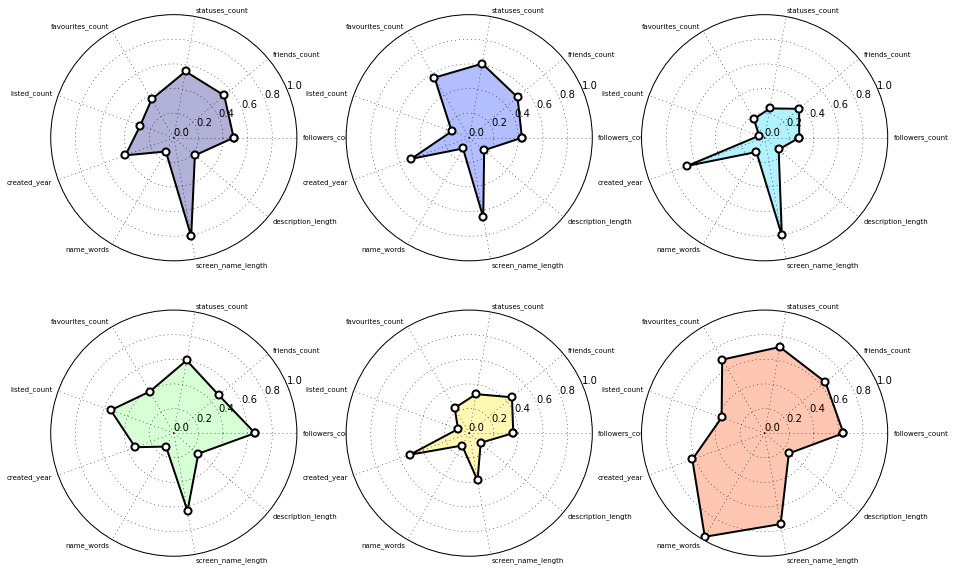

In [13]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(y)
for j, cluster in enumerate(clusters):    
    x_c = x[y == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(3, 3, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / k))

plt.show()

Первый и второй кластеры похожи, за исключением признака listed_count. Вероятнее всего из-за этого признака эти кластеры и поделились. К тому у первого кластера преобладает признак screen_name_length.

Третий кластер похож на пятый. Но у третьего признаки created_year и screen_name_length более значимы.

Особо выделяются четвертый и шестой кластеры. У четвертого кластера преобладание идет в сторону признака followers_count в комбинации с statuses_count и listed_count. А у шестого кластера преобладает признак name_words при этом комбинируя все признаки, кроме малозначимых для кластера description_length и listed_count

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.